In [ ]:
# RAPIDS Setup
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
!wget https://raw.githubusercontent.com/rapidsai/rapidsai-csp/main/colab/rapids-colab.sh
!bash rapids-colab.sh

!pip install tweepy scikit-learn xgboost lightgbm wordcloud


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 592 (delta 125), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (592/592), 194.79 KiB | 1.66 MiB/s, done.
Resolving deltas: 100% (299/299), done.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.12 environment at: /usr
Resolved 173 packages in 13.20s
 Downloaded cuproj-cu12
 Downloaded rmm-cu12
 Downloaded shapely
 Downloaded pylibcugraph-cu12
 Downloaded datashader
 Downloaded dask
 Downloaded cudf-cu12
 Downloaded ucx-py-cu12
 Downloaded libkvikio-cu12
 Downloaded bokeh
 Downloaded cugraph-cu12
 Downloaded librmm-cu12
 Downloaded cuspatial-cu12
 Downloaded cucim-cu12
 Downloaded cuml-cu12
 Downloaded libcuspatial-cu12
 Downloaded libraft-cu12
 Downloaded pylibcudf-cu12
 Downloaded raft-dask-cu12
 Downloaded libcuml-cu12
 Downloaded libcudf-cu12
 Downloaded libcuv

In [59]:
import cudf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import tweepy
import requests
import joblib


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload twitter_training.csv

import cudf


df = cudf.read_csv("twitter_training.csv", header=None)
df.columns = ['tweet_id', 'entity', 'sentiment', 'text']


df = df[['text', 'sentiment']]

sentiment_map = {'Positive': 1, 'Negative': 0, 'Neutral': 2}
df = df[df['sentiment'].isin(sentiment_map.keys())]  # Filter valid labels
df['sentiment'] = df['sentiment'].map(sentiment_map)

df = df.dropna()
df = df.drop_duplicates()
df = df[df['text'].str.len() > 3]

df_pd = df.to_pandas()


Saving twitter_training.csv to twitter_training.csv


In [ ]:
tfidf = TfidfVectorizer(max_features=5000)

X = tfidf.fit_transform(df_pandas['text'])
y = df_pandas['sentiment'].astype('int32')

joblib.dump(tfidf, 'tfidf_vectorizer.pkl')  

print("TF-IDF features extracted. Shape:", X.shape)


TF-IDF features extracted. Shape: (61120, 5000)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression 
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
log_acc = accuracy_score(y_test, log_pred)
print(f"Logistic Regression Accuracy: {log_acc:.4f}")

# XGBoost
dtrain = xgb.DMatrix(X, label=y)
dtest = xgb.DMatrix(X_test)
xgb_params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 6,
    'eval_metric': 'mlogloss'
}
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100)
xgb_pred = xgb_model.predict(dtest)
xgb_acc = accuracy_score(y_test, xgb_pred)
print(f"XGBoost Accuracy: {xgb_acc:.4f}")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_acc:.4f}")


Logistic Regression Accuracy: 0.7724
XGBoost Accuracy: 0.7885
Random Forest Accuracy: 0.9108


In [ ]:
import joblib

joblib.dump(log_model, 'logistic_regression_model.pkl')


xgb_model.save_model('xgboost_model.json') 

joblib.dump(rf_model, 'random_forest_model.pkl')

print("Models have been saved.")


Models have been saved.


In [ ]:
results = {
    'Logistic Regression': log_acc,
    'XGBoost': xgb_acc,
    'Random Forest': rf_acc
}

print("==== Model Comparison ====")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")

# Choose best model (for this example, we pick the one with highest accuracy)
best_model_name = max(results, key=results.get)
print("Best performing model:", best_model_name)

# Load the best model
if best_model_name == "Logistic Regression":
    best_model = lr_model
elif best_model_name == "XGBoost":
    best_model = xgb_model  
else:
    best_model = rf_model


==== Model Comparison ====
Logistic Regression: 0.7724
XGBoost: 0.7885
Random Forest: 0.9108
Best performing model: Random Forest


In [ ]:
import requests

# Twitter API credentials
bearer_token = "YOUR TWITTER BEARER TOKEN"  # Replace with your actual Bearer Token from twitter developer portal 
username = "narendramodi" 


def create_headers(token):
    return {"Authorization": f"Bearer {token}"}


def get_user_id(headers, username):
    url = f"https://api.twitter.com/2/users/by/username/{username}"
    response = requests.get(url, headers=headers)


    if response.status_code != 200:
        print(f"Error: Unable to fetch user ID. Response code: {response.status_code}")
        print(f"Error details: {response.json()}")
        return None
    else:
        return response.json().get('data', {}).get('id', None)

def get_tweets(user_id, headers, max_results=20):
    url = f"https://api.twitter.com/2/users/{user_id}/tweets"
    params = {
        "tweet.fields": "created_at",
        "max_results": max_results
    }
    response = requests.get(url, headers=headers, params=params)

    if response.status_code != 200:
        print(f"Error: Unable to fetch tweets. Response code: {response.status_code}")
        print(f"Error details: {response.json()}")
        return []


    return [tweet["text"] for tweet in response.json().get("data", [])]

headers = create_headers(bearer_token)
user_id = get_user_id(headers, username)

if user_id:
    tweets = get_tweets(user_id, headers, max_results=20) 
    print("Fetched Tweets:")
    for tweet in tweets:
        print(tweet)
else:
    print("Failed to fetch user ID.")


Fetched Tweets:
Heartiest congratulations to @_FriedrichMerz on assuming office as the Federal Chancellor of Germany. I look forward to working together to further cement the India-Germany Strategic Partnership.
Speaking at the ABP Network India@2047 Summit. @ABPNews

https://t.co/p0GzjptHUk
Delighted to speak with my friend PM @Keir_Starmer. In a historic milestone, India and the UK have successfully concluded an ambitious and mutually beneficial Free Trade Agreement, along with a Double Contribution Convention. These landmark agreements will further deepen our
Spoke with my friend @AlboMP to personally congratulate him on his party’s historic victory. We agreed to work together with renewed vigour to advance the India-Australia Comprehensive Strategic Partnership and explore new areas of cooperation.
പത്മശ്രീ പുരസ്കാരജേതാവായ കെ വി റാബിയ-ജിയുടെ വിയോഗത്തിൽ വേദനയുണ്ട്. സാക്ഷരത മെച്ചപ്പെടുത്തുന്നതിൽ മാർഗദീപമേകിയ അവരുടെ  പ്രവർത്തനങ്ങൾ എന്നും ഓർമിക്കപ്പെടും. അവരുടെ ധൈര്യവും ദൃഢനിശ്ചയവും, പ

In [ ]:
import cudf
import joblib

tweets_df = cudf.DataFrame({'tweet': tweets})

tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')  

tweets_pandas = tweets_df['tweet'].to_pandas()

X_live = tfidf_vectorizer.transform(tweets_pandas)

X_live = X_live.toarray()

print("Preprocessed and vectorized tweets:")
print(X_live)

print("Vector for the first tweet:", X_live[0])  


Preprocessed and vectorized tweets:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vector for the first tweet: [0. 0. 0. ... 0. 0. 0.]


In [ ]:
rf_model = joblib.load('random_forest_model.pkl')  # Load previously saved Random Forest model

rf_predictions = rf_model.predict(X_live)

sentiment_map_reverse = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
predicted_sentiments = [sentiment_map_reverse[pred] for pred in rf_predictions]

print("\nPredicted Sentiments for Live Tweets:")
for tweet, sentiment in zip(tweets, predicted_sentiments):
    print(f"Tweet: {tweet}\nPredicted Sentiment: {sentiment}\n")



Predicted Sentiments for Live Tweets:
Tweet: Heartiest congratulations to @_FriedrichMerz on assuming office as the Federal Chancellor of Germany. I look forward to working together to further cement the India-Germany Strategic Partnership.
Predicted Sentiment: Positive

Tweet: Speaking at the ABP Network India@2047 Summit. @ABPNews

https://t.co/p0GzjptHUk
Predicted Sentiment: Neutral

Tweet: Delighted to speak with my friend PM @Keir_Starmer. In a historic milestone, India and the UK have successfully concluded an ambitious and mutually beneficial Free Trade Agreement, along with a Double Contribution Convention. These landmark agreements will further deepen our
Predicted Sentiment: Neutral

Tweet: Spoke with my friend @AlboMP to personally congratulate him on his party’s historic victory. We agreed to work together with renewed vigour to advance the India-Australia Comprehensive Strategic Partnership and explore new areas of cooperation.
Predicted Sentiment: Neutral

Tweet: പത്മശ്ര

In [ ]:
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [ ]:
print("\n=== Summary ===")
for tweet, sentiment in zip(tweets, predicted_sentiments):
    print(f"Tweet: {tweet}\nPredicted Sentiment: {sentiment}\n")



=== Summary ===
Tweet: Heartiest congratulations to @_FriedrichMerz on assuming office as the Federal Chancellor of Germany. I look forward to working together to further cement the India-Germany Strategic Partnership.
Predicted Sentiment: Positive

Tweet: Speaking at the ABP Network India@2047 Summit. @ABPNews

https://t.co/p0GzjptHUk
Predicted Sentiment: Neutral

Tweet: Delighted to speak with my friend PM @Keir_Starmer. In a historic milestone, India and the UK have successfully concluded an ambitious and mutually beneficial Free Trade Agreement, along with a Double Contribution Convention. These landmark agreements will further deepen our
Predicted Sentiment: Neutral

Tweet: Spoke with my friend @AlboMP to personally congratulate him on his party’s historic victory. We agreed to work together with renewed vigour to advance the India-Australia Comprehensive Strategic Partnership and explore new areas of cooperation.
Predicted Sentiment: Neutral

Tweet: പത്മശ്രീ പുരസ്കാരജേതാവായ കെ വ

In [ ]:
import joblib
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

sentiment_map_reverse = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}

log_model = joblib.load('logistic_regression_model.pkl')
rf_model = joblib.load('random_forest_model.pkl')
xgb_model = xgb.Booster()
xgb_model.load_model('xgboost_model.json')

tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

input_text = input("Enter a tweet to analyze sentiment: ")
input_vector = tfidf_vectorizer.transform([input_text]).toarray()

#Logistic Regression
log_pred = log_model.predict(input_vector)[0]
log_sentiment = sentiment_map_reverse[log_pred]

#Random Forest
rf_pred = rf_model.predict(input_vector)[0]
rf_sentiment = sentiment_map_reverse[rf_pred]

#XGBoost
xgb_input = xgb.DMatrix(input_vector)
xgb_pred = int(xgb_model.predict(xgb_input)[0])
xgb_sentiment = sentiment_map_reverse[xgb_pred]

# Display results
print("\n===== Sentiment Prediction Results =====")
print(f"Logistic Regression: {log_sentiment}")
print(f"Random Forest: {rf_sentiment}")
print(f"XGBoost: {xgb_sentiment}")


Enter a tweet to analyze sentiment: My day was decent today. Wasn't that bad but could have been better. But I was happy but still it was mid

===== Sentiment Prediction Results =====
Logistic Regression: Neutral
Random Forest: Positive
XGBoost: Positive


<ipython-input-68-0a17f2461f1c>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=scores, palette=palette)


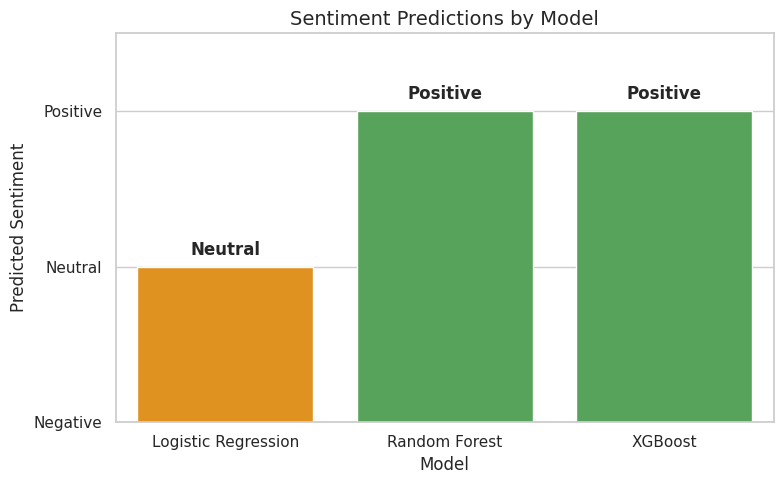

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']
sentiment_labels = [log_sentiment, rf_sentiment, xgb_sentiment]

sentiment_to_score = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
scores = [sentiment_to_score[s] for s in sentiment_labels]

plt.figure(figsize=(8, 5))
palette = ['#f44336' if s == 'Negative' else '#4caf50' if s == 'Positive' else '#ff9800' for s in sentiment_labels]
sns.barplot(x=model_names, y=scores, palette=palette)

for i, (score, label) in enumerate(zip(scores, sentiment_labels)):
    plt.text(i, score + 0.05, label, ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(0, 2.5)
plt.yticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.title("Sentiment Predictions by Model", fontsize=14)
plt.xlabel("Model")
plt.ylabel("Predicted Sentiment")
plt.tight_layout()
plt.show()


<ipython-input-71-c0d597e71cd3>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=models, palette="viridis")


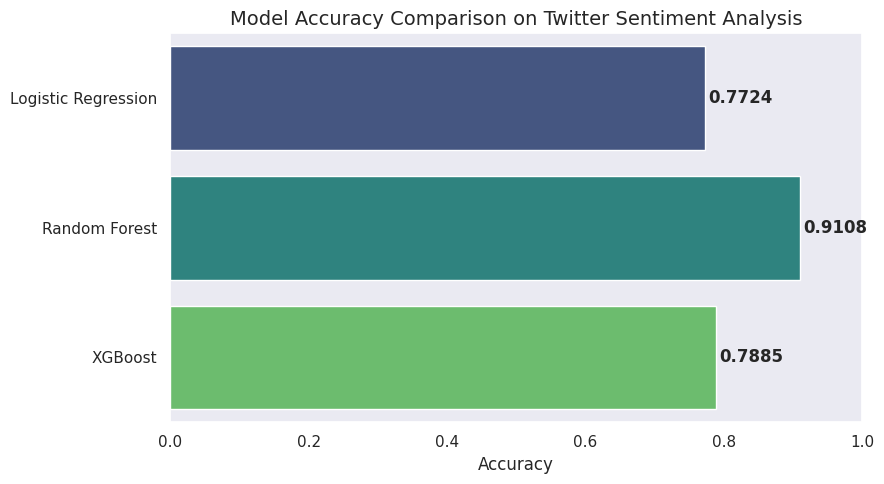

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


models = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracies = [log_acc, rf_acc, xgb_acc]

sns.set(style="dark")
plt.figure(figsize=(9, 5))

sns.barplot(x=accuracies, y=models, palette="viridis")

for index, value in enumerate(accuracies):
    plt.text(value + 0.005, index, f"{value:.4f}", va='center', fontsize=12, fontweight='bold')

# Chart labels
plt.title("Model Accuracy Comparison on Twitter Sentiment Analysis", fontsize=14)
plt.xlabel("Accuracy")
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()
